# Proyecto: Análisis de mercado inmobiliario

En este proyecto vamos a trabajar con un dataset de propiedades en venta publicado en el portal [Properati](www.properati.com.ar).


## Problema

Recientemente te has incorporado al equipo de Datos de una gran inmobiliaria. La primera tarea que se te asigna es ayudar a los tasadores/as a valuar las propiedades, ya que es un proceso difícil y, a veces, subjetivo. Para ello, propones crear un modelo de Machine Learning que, dadas ciertas características de la propiedad, prediga su precio de venta.


Los datos que nos podrían servir para a trabajar con el problema:

---


1. Ubicación. Ciudad, barrio, calle.
1. Orientación al sol.
1. Cantidad de ambientes de cada tipo.
1. Metros cuadrados cubiertos, descubiertos, semicubiertos.
1. Ambientes exteriores: jardin, terraza, balcon, pileta, lavadero, garage.

Estas son algunas caracteristicas generales de las propiedades residenciales urbanas de la Ciudad de Buenos Aires. Seguramente existen otras variables dependiendo del valor del dolar, del hierro, del cemento, el valor de la mano de obra de la construcción. Son otro tipo de variables que dependen del contexto socio-economico y de la coyuntura.

### 2. Análisis Exploratorio de Datos

En esta sección, realizamos un Análisis Exploratorio de Datos sobre el dataset de propiedades de Properati. 

Creamos el entorno de trabajo.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set_palette("hls", 8)

Cargamos el dataset e imprimimos en pantalla sus primeras cinco instancias y su tamaño.

In [ ]:
properati = pd.read_csv("DS_Proyecto_01_Datos_Properati.csv",parse_dates=['created_on'])
properati.shape

(146660, 19)

In [ ]:
properati.head()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta


In [ ]:
properati.tail()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
146655,2019-07-31,2019-08-13,2019-07-31,-34.816348,-58.181963,Argentina,Bs.As. G.B.A. Zona Sur,Berazategui,2.0,1.0,1.0,54.0,48.0,165000.0,USD,Departamento en Venta en Barrio Privado Barran...,Departamento de 2 ambientesCocina con alacena ...,Departamento,Venta
146656,2019-07-31,2019-08-14,2019-07-31,-34.446459,-58.937810,Argentina,Bs.As. G.B.A. Zona Norte,Pilar,4.0,3.0,2.0,164.0,90.0,130000.0,USD,Venta departamentos tres dormitorios jardín co...,Muy buen duplex a estrenar en dos plantas más ...,Departamento,Venta
146657,2019-07-31,2019-08-14,2019-07-31,-34.444633,-58.981606,Argentina,Bs.As. G.B.A. Zona Norte,Pilar,1.0,1.0,1.0,50.0,35.0,73000.0,USD,Venta departamento de un ambiente Manzanares C...,"En los Condominios de Campo Manzanares Chico, ...",Departamento,Venta
146658,2019-07-31,2019-08-14,2019-07-31,-34.444830,-58.981796,Argentina,Bs.As. G.B.A. Zona Norte,Pilar,2.0,1.0,1.0,38.0,38.0,68000.0,USD,Departamento en Venta. Manzanares chico.,Broker: Maria 11Departamento de dos ambientes ...,Departamento,Venta
146659,2019-07-31,2019-10-12,2019-07-31,-34.444760,-58.981885,Argentina,Bs.As. G.B.A. Zona Norte,Pilar,3.0,2.0,1.0,75.0,75.0,98000.0,USD,Departamento en venta en Manzanares Chico,"Departamento en el Barrio Manzanares Chico , e...",Departamento,Venta


Estudiamos las primeras columnas relacionadas a la fecha de publicacion, la fecha de comienzo y la fecha de fin de la publicación. Observamos que *start_date* y *created_on* dan la misma información (en diferente formato). Todas las instancias estan publicadas con 00 horas, minutos y segundos. Se plantea para un futuro estudio la duración de la publicación en la base de datos como posible información útil.

In [ ]:
# Aca probamos que start_date y created_on coinciden para dia, mes y año
#print(properati.start_date[0])
#print(str(properati.created_on[0])[0:10])
for i in range(146660):
    if properati.start_date[i] != str(properati.created_on[i])[0:10]:
        print(i)

In [ ]:
# Aca probamos que created_on para hora, minuto, segundo siempre es 00
print(str(properati.created_on[0])[11:])
for i in range(146660):
    if str(properati.created_on[i])[11:] != str(properati.created_on[0])[11:]:
        print(i)

00:00:00


In [ ]:
import re
from datetime import datetime

regex_match = re.match(r'.*?(\d+), (\d+), (\d+), (\d+), (\d+).*', 'datetime.datetime(2017, 1, 1, 4, 36)').groups()
d = datetime(*[int(i) for i in regex_match])

ds = datetime(int(properati.start_date[1020][0:4]), 
             int(properati.start_date[1020][5:7]),
             int(properati.start_date[1020][8:10]),
             0, 0)

de = datetime(int(properati.end_date[1020][0:4]), 
             int(properati.end_date[1020][5:7]),
             int(properati.end_date[1020][8:10]),
             0, 0)
print(ds.isoformat())
print(de.isoformat())
print(de-ds)

2019-04-25T00:00:00
2019-06-08T00:00:00
44 days, 0:00:00


Observamos los nombres de las columnas de nuestro dataset junto con el tipo de dato que almacenan cada una de ellas.

In [ ]:
properati.dtypes

start_date                 object
end_date                   object
created_on         datetime64[ns]
lat                       float64
lon                       float64
l1                         object
l2                         object
l3                         object
rooms                     float64
bedrooms                  float64
bathrooms                 float64
surface_total             float64
surface_covered           float64
price                     float64
currency                   object
title                      object
description                object
property_type              object
operation_type             object
dtype: object

Visualizamos cuantos valores faltantes hay en cada una de las columnas del dataset.

In [ ]:
faltantes = properati.isnull()
faltantes.sum()

start_date             0
end_date               0
created_on             0
lat                 9925
lon                 9959
l1                     0
l2                     0
l3                     0
rooms                  0
bedrooms               0
bathrooms           5957
surface_total      20527
surface_covered    21614
price                  0
currency               0
title                  0
description            0
property_type          0
operation_type         0
dtype: int64

Las variables *l1*, *currency* y *operation_type* toman el mismo valor para todas las instancias del dataset, por lo tanto no las tenemos en cuenta. Mientras que *title* y *description* son textos que describien las publicaciones.

In [ ]:
print('Todas las propiedades del dataset cumplen:')
print('PAIS:', properati['l1'].unique())
print('MONEDA:', properati['currency'].unique())
print('TIPO DE OPERACIÓN:', properati['operation_type'].unique())

Todas las propiedades del dataset cumplen:
PAIS: ['Argentina']
MONEDA: ['USD']
TIPO DE OPERACIÓN: ['Venta']


Estudiamos las variables *lat* y *lon* y realizamos gráficos georeferenciando las ubicaciones de las publicaciones de nuestros datos. Filtamos algunas intancias que parecen no correponder con ubicaciones del Gran Buenos Aires.

Boxplot de *lat*, truncado:

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


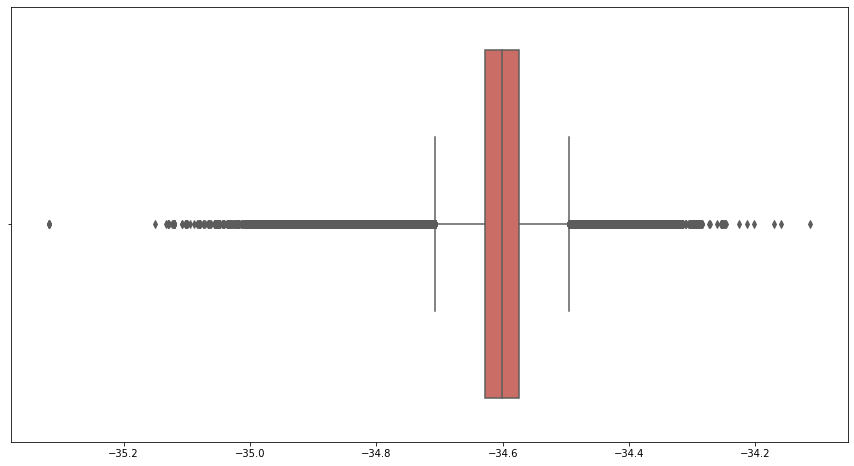

In [ ]:
sns.boxplot(list(properati.lat[properati['lat']<-33]))
plt.show()

Boxplot de *lon*, truncado:

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


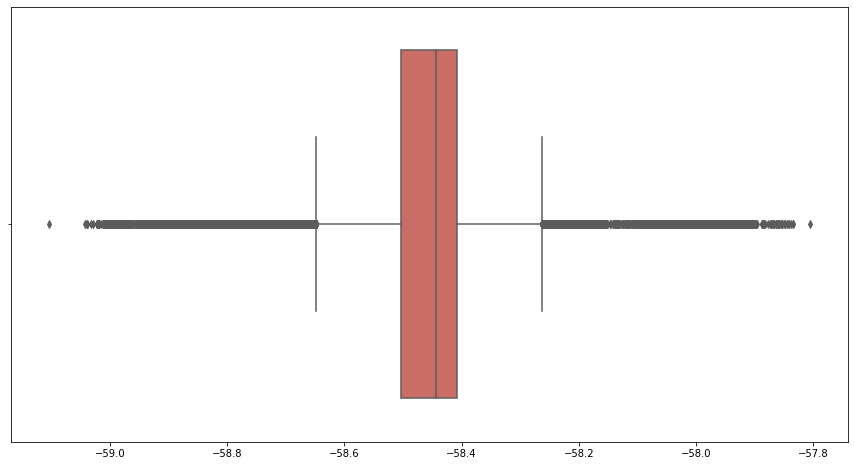

In [ ]:
sns.boxplot(list(properati.lon[properati['lon']>-60]))
plt.show()

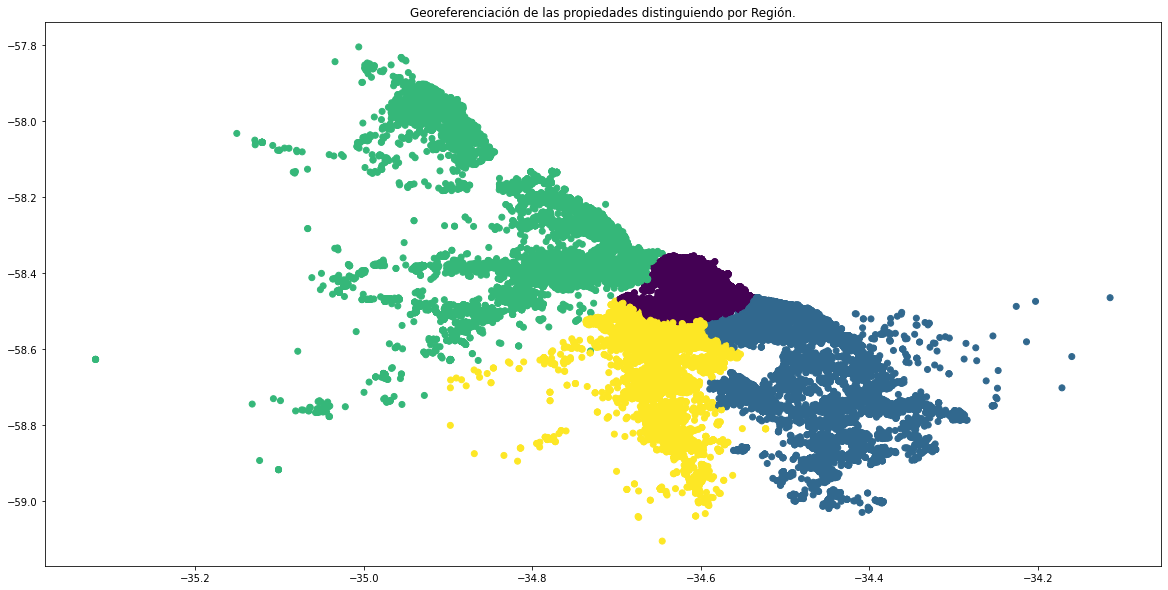

In [ ]:
prop_geo = properati[properati['lat']<-33]
prop_geo = prop_geo[prop_geo['lon']>-60]
x=prop_geo['lat']
y=prop_geo['lon']
colo=prop_geo['l2']
colo.replace({"Capital Federal": 0, "Bs.As. G.B.A. Zona Norte": 1, "Bs.As. G.B.A. Zona Sur": 2, "Bs.As. G.B.A. Zona Oeste": 3}, inplace=True)

plt.figure(figsize=(20,10))
plt.scatter(x, y, c = colo)
plt.title('Georeferenciación de las propiedades distinguiendo por Región.')
plt.show()

Mostramos en un mapa interactivo las primeras 500 propiedades. Agregamos la opción de ubicar especificamente una propiedad en particular en el mismo mapa:

In [ ]:
import folium

In [ ]:
numero = input('Introduce un numero entero de propiedad a geolocalizar (menor a ' + str(len(x)-1) + ') que se marcara en rojo:')
m = folium.Map(location=[x.iloc[int(numero)], y.iloc[int(numero)]], zoom_start=13)

for i in range(500):
  folium.Marker(
    location=[x.iloc[i], y.iloc[i]],
  ).add_to(m)

m.add_child(folium.LatLngPopup())  

folium.Marker(
    location=[x.iloc[int(numero)], y.iloc[int(numero)]], 
    popup="Ubicación seleccionada",
    icon=folium.Icon(color="red")
  ).add_to(m)

m

Introduce un numero entero de propiedad a geolocalizar (menor a 136696) que se marcara en rojo:1


Estudiamos la variable *property_type*:

In [ ]:
print('Hay en el dataset', len(properati['property_type'].unique()), 'tipos de propiedades distintos. La siguiente tabla muestra cuantas instancias de cada tipo de propiedad hay:')
cantidad_tipos_de_propiedad = properati['property_type'].value_counts()
print(cantidad_tipos_de_propiedad)

Hay en el dataset 10 tipos de propiedades distintos. La siguiente tabla muestra cuantas instancias de cada tipo de propiedad hay:
Departamento       107326
Casa                21521
PH                  14298
Lote                 1312
Oficina               658
Otro                  374
Local comercial       325
Casa de campo         322
Depósito              265
Cochera               259
Name: property_type, dtype: int64


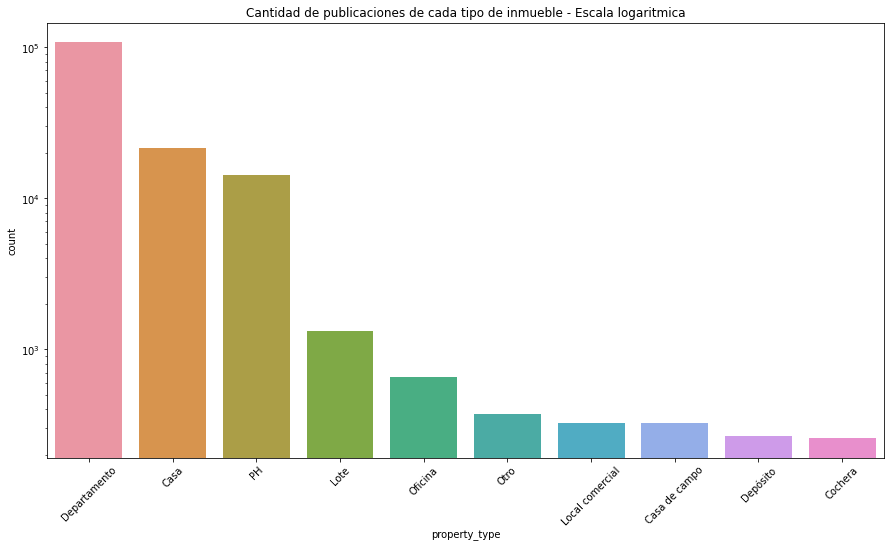

In [ ]:
plt.rcParams['figure.figsize'] = (15,8)
chart = sns.countplot(x='property_type',data=properati, order = properati['property_type'].value_counts().index)
chart.set_xticklabels(chart.get_xticklabels(),rotation=45)
chart.set_title("Cantidad de publicaciones de cada tipo de inmueble - Escala logaritmica")
plt.yscale('log')
plt.show()

En la tabla y el gráfico anterior podemos observar como la mayor cantidad de instancias del dataset se dan en propiedades de los tipos: Departamento, Casa y PH. Los 7 restantes tipos de propiedad tienen menos de 1500 cada uno instancias que representa un %1 sobre la cantidad de instancias iniciales del dataset. Si nos quedamos con las instancias cuyas propiedades son de tipo Departamento, PH y Casa, obtenemos 143.145 instancias que reperesenta un 97,6% de las instancias iniciales.

Estudiamos de qué regiones son las publicaciones, información que obtenemos de las variables *l2* y *l3*:

In [ ]:
print('La siguiente tabla muestra cuantas instancias de cada región hay:')
print(properati.l2.value_counts())

La siguiente tabla muestra cuantas instancias de cada región hay:
Capital Federal             92539
Bs.As. G.B.A. Zona Norte    24282
Bs.As. G.B.A. Zona Sur      17173
Bs.As. G.B.A. Zona Oeste    12666
Name: l2, dtype: int64


In [ ]:
print('La siguiente tabla muestra cuantas instancias de cada barrio hay:')
print(properati.l3.value_counts())

La siguiente tabla muestra cuantas instancias de cada barrio hay:
Palermo            13073
Tigre               8718
Almagro             7527
Belgrano            6935
Caballito           6650
                   ...  
Cañuelas             108
Villa Soldati         69
Villa Riachuelo       42
Marcos Paz            35
Catalinas              5
Name: l3, Length: 89, dtype: int64


Vemos que hay propiedades de 89 barrios diferentes. Dado que no vemos el total de los barrios, a continuacion mostramos gráficos de barras correspondientes a las regiones y a los barrios.

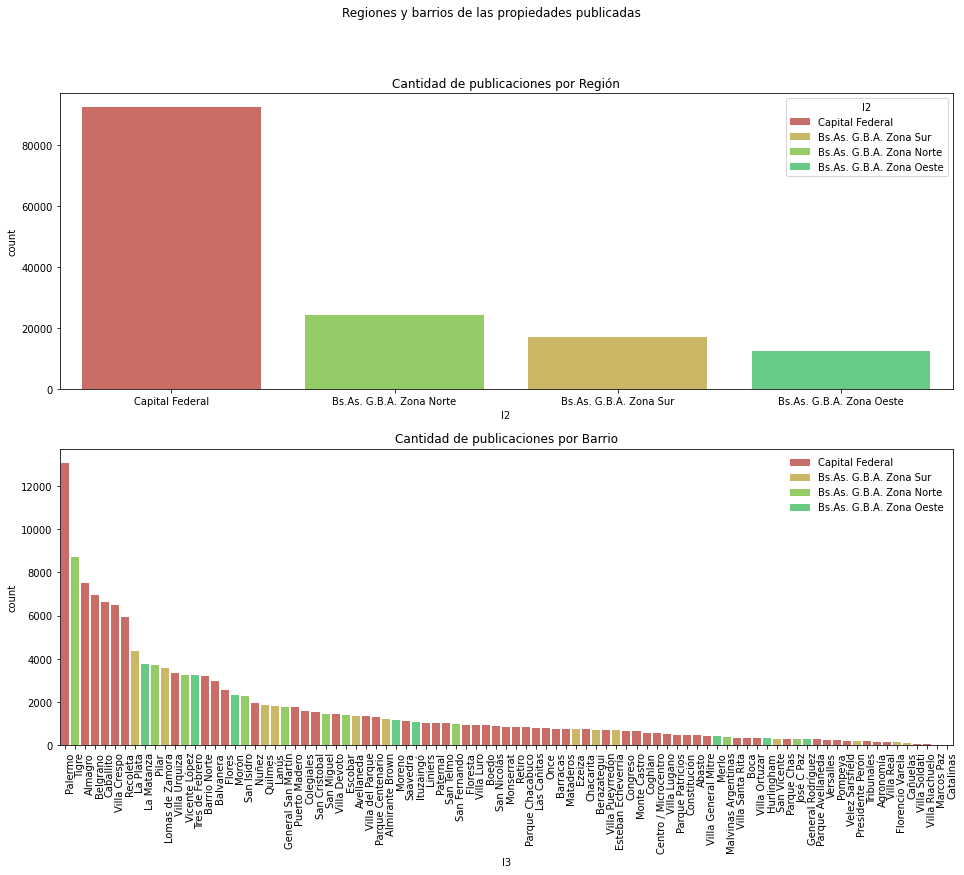

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(16,12))
fig.suptitle('Regiones y barrios de las propiedades publicadas')
# Plot the data
chart_l2 = sns.countplot(ax=axes[0], x='l2', hue = "l2", data=properati, order = properati['l2'].value_counts().index, dodge=False)
axes[0].set_title('Cantidad de publicaciones por Región')

chart_l3 = sns.countplot(ax=axes[1], x='l3',data=properati, hue = "l2", order = properati['l3'].value_counts().index, dodge=False)
chart_l3.set_xticklabels(chart_l3.get_xticklabels(),rotation=90,ha='left')
axes[1].set_title('Cantidad de publicaciones por Barrio')
plt.legend(loc='upper right', frameon=False)

# Show the plot
plt.show()

Por lo analizado previamente las tres clases más abundantes de tipos de propiedades son: Departamento, Casa y PH. Por otro lado, la región con más propiedades publicadas es Capital Federal. Al filtrar solamente estas instancias obtenemos 91.485 instancias que son aproximadamente un 62% del tamaño inicial del dataset.

In [ ]:
properati_filt = properati[properati.property_type.isin(['Departamento', 'Casa', 'PH'])] 
properati_filt = properati_filt[properati_filt.l2=='Capital Federal']
properati_filt.shape

(91485, 19)

Se cumple el checkpoint.

A continuación vemos los principales estadisticos de las columnas numéricas. A partir de las cuales obtenemos histogramas y gráficos boxplot.

In [ ]:
properati_filt.describe()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,86951.000000,86937.000000,91485.000000,91485.000000,89314.000000,82568.000000,82250.000000,9.148500e+04
mean,-34.599081,-58.436002,2.964278,1.960278,1.560147,112.626369,94.966310,2.595003e+05
std,0.023957,0.036297,1.314704,1.072946,0.860309,980.713664,778.515243,3.222654e+05
min,-34.696419,-58.530468,1.000000,0.000000,1.000000,10.000000,1.000000,6.000000e+03
25%,-34.613757,-58.459605,2.000000,1.000000,1.000000,49.000000,44.000000,1.200000e+05
50%,-34.599446,-58.433789,3.000000,2.000000,1.000000,71.000000,63.000000,1.750000e+05
75%,-34.584148,-58.410143,4.000000,3.000000,2.000000,111.000000,96.000000,2.790000e+05
max,-34.535818,-58.353930,26.000000,15.000000,14.000000,126062.000000,126062.000000,3.243423e+07


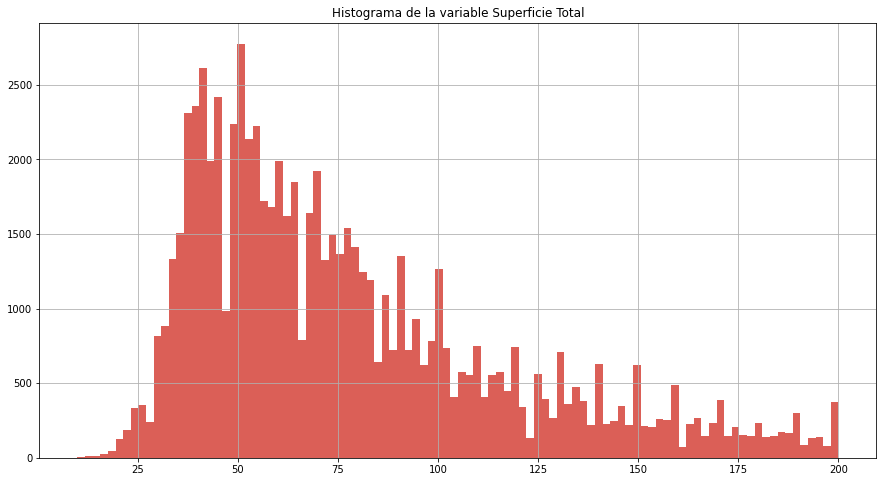

In [ ]:
properati_filt.surface_total[properati_filt['surface_total']<=200].hist(bins=100)
plt.title("Histograma de la variable Superficie Total")
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


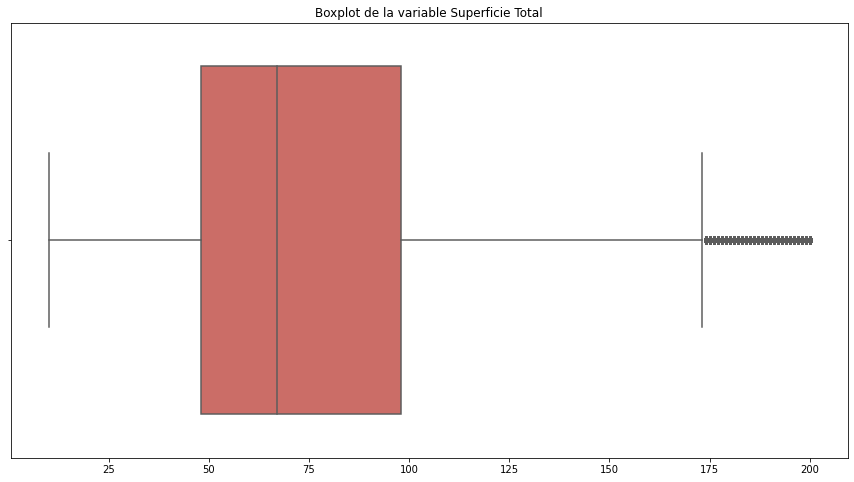

In [ ]:
sns.boxplot(list(properati_filt.surface_total[properati_filt['surface_total']<=200]))
plt.title('Boxplot de la variable Superficie Total')
plt.show()

Filtamos el dataset por la columna *superficie total* cuyos valores varian entre 15 y 200 metros cuadrados. Nos quedamos con las pulicaciones que cumplen la condición de tener mayor superficie total que superficie cubierta. Imprimimos el tamaño del dataframe resultante en cada caso.

In [ ]:
properati_filt= properati_filt[properati_filt['surface_total']<=200]
properati_filt= properati_filt[properati_filt['surface_total']>=15]
properati_filt.shape

(76061, 19)

In [ ]:
properati_filt=properati_filt[properati_filt.surface_total >= properati_filt.surface_covered]
properati_filt.shape

(74908, 19)

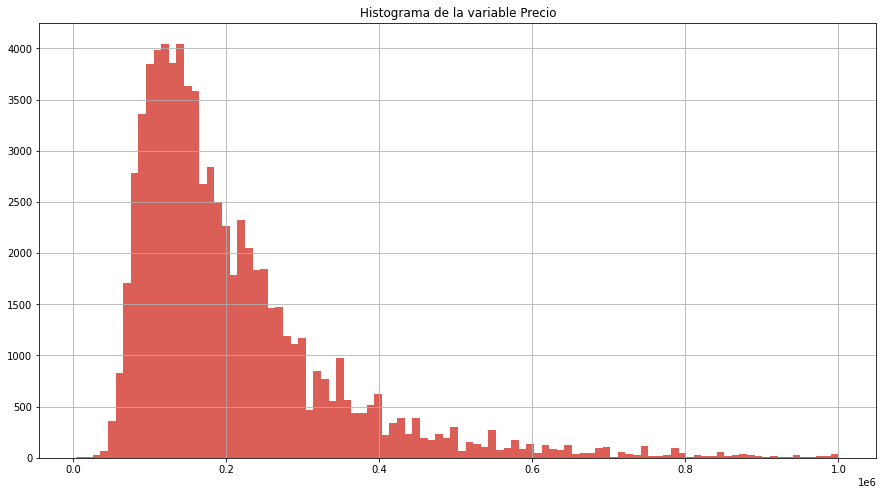

In [ ]:
properati_filt.price[properati_filt['price']<=1000000].hist(bins=100)
plt.title("Histograma de la variable Precio")
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


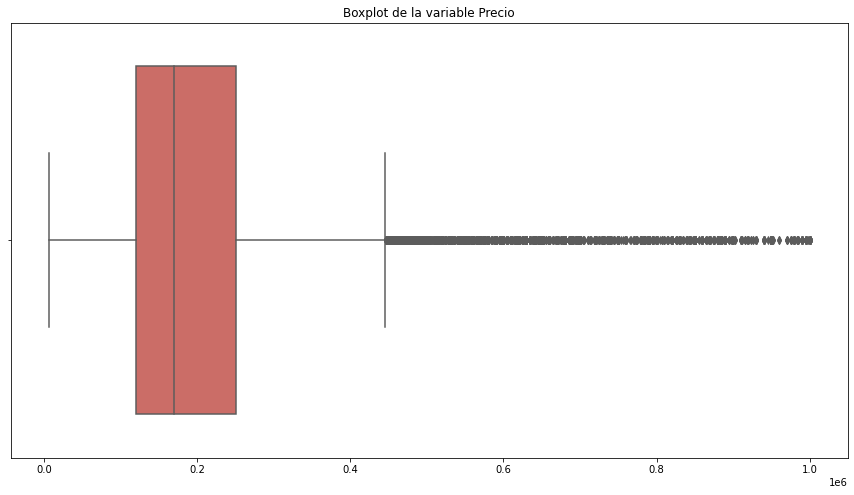

In [ ]:
sns.boxplot(list(properati_filt.price[properati_filt['price']<=1000000]))
plt.title('Boxplot de la variable Precio')
plt.show()

Filtamos el dataset por la columna *precio* cuyos valores varian entre 100.000 y 450.000 dolares. Imprimimos el tamaño del dataframe resultante en cada caso.

In [ ]:
properati_filt = properati_filt[properati_filt['price']>=100000]
properati_filt = properati_filt[properati_filt['price']<=450000]
properati_filt.shape

(59529, 19)

A continuación descartamos las columnas *lat* y *lon* con el objetivo de realizar un pairplot de las features numéricas distinguiendo por *tipo de propiedad*.

In [ ]:
properati_filt = properati_filt.drop(['lat','lon'],axis = 1)

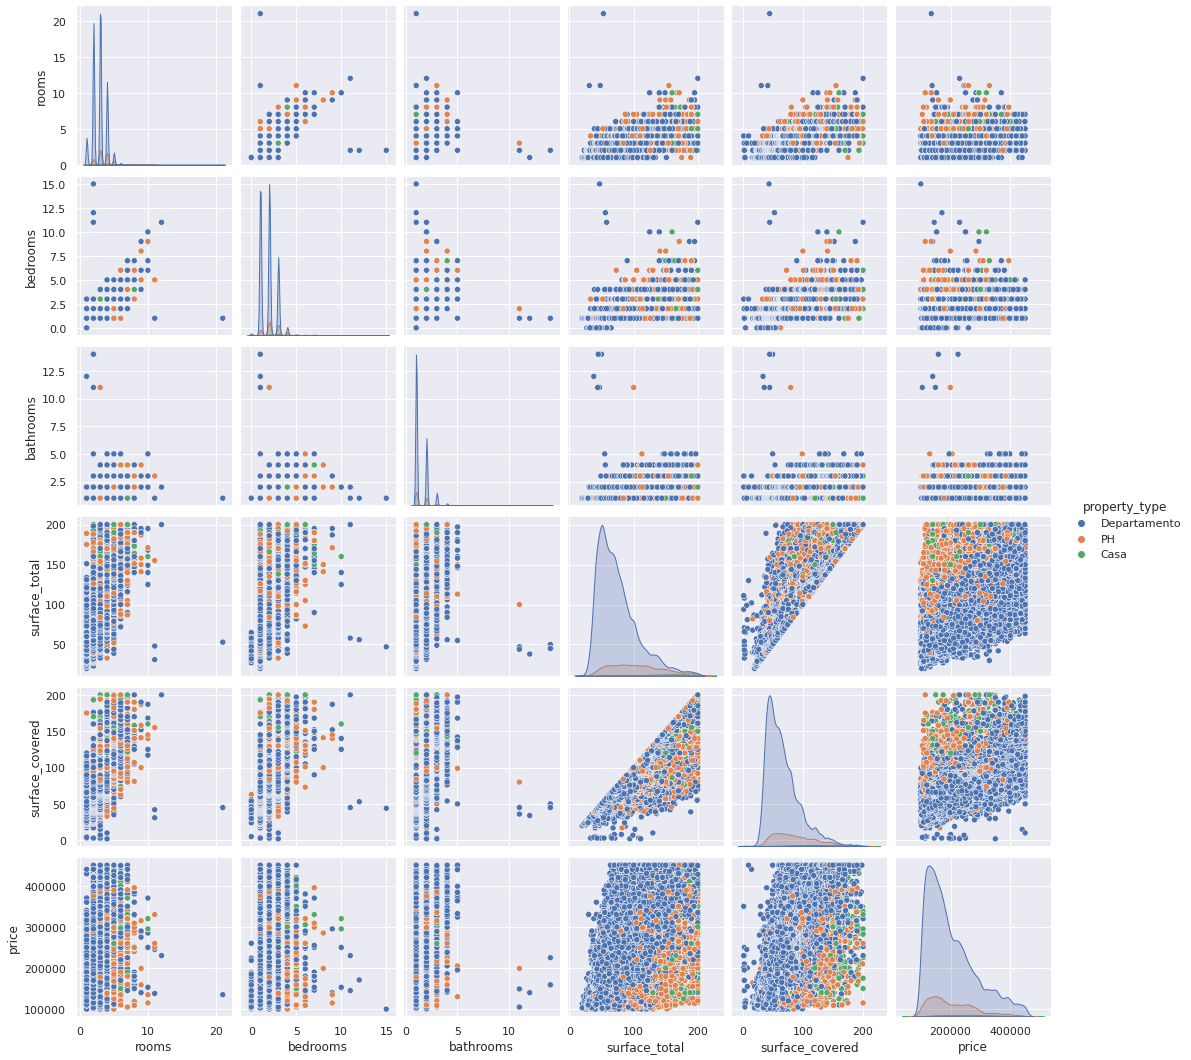

In [ ]:
sns.set() 
par= sns.pairplot(properati_filt, hue = 'property_type')
plt.show()

Podemos ver que las variables *rooms*, *bedrooms* y *bathrooms* toman valores discretos entre 0 y 20. También podemos apreciar que las variables *rooms* y *bedrooms* estan correlacionadas sobre la recta $y=x$, esto lo veremos mejor proximamente.

Estudiamos la correlación entre las variables mencionadas para todo el dataset. Además comparamos filtrando por lo tres tipos de propiedad estudiados.

In [ ]:
df = properati_filt
df.columns

Index(['start_date', 'end_date', 'created_on', 'l1', 'l2', 'l3', 'rooms',
       'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price',
       'currency', 'title', 'description', 'property_type', 'operation_type'],
      dtype='object')

In [ ]:
df = df.drop(['start_date', 'end_date', 'created_on', 'l1', 'l2', 'l3', 'currency', 'title', 'description', 'operation_type'], axis =1)

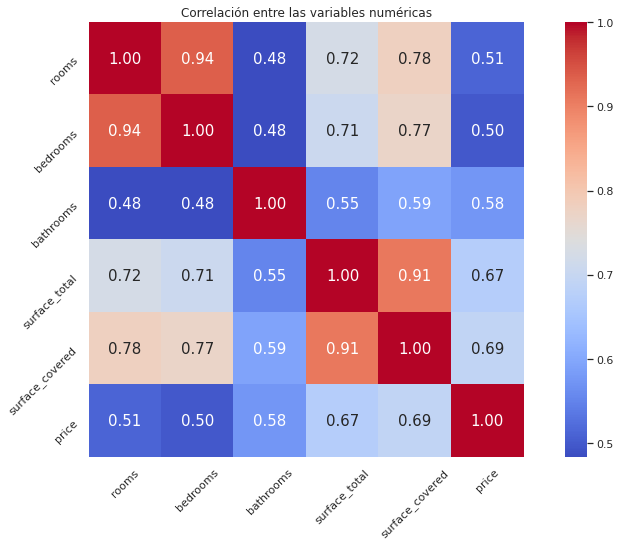

In [ ]:
corr = df.drop(['property_type'], axis =1).corr()
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= df.drop(['property_type'], axis =1).columns, 
           yticklabels= df.drop(['property_type'], axis =1).columns,
           cmap= 'coolwarm')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.title('Correlación entre las variables numéricas')
plt.show()

Podemos observar que las mejores variables para predecir el precio son las correspondientes a la superficie, tanto para *superficie cubierta* como para *superficie total* (estas dos variables estan altamente correlacionadas entre sí). Además vemos que *rooms* y *bedrooms* tienen alta correlación. En el siguiente bloque vemos el heat-map para cada uno de los tres tipos de propiedades con más instancias. Se puede notar como las correlaciones son más fuertes en las propiedades de tipo Departamento.

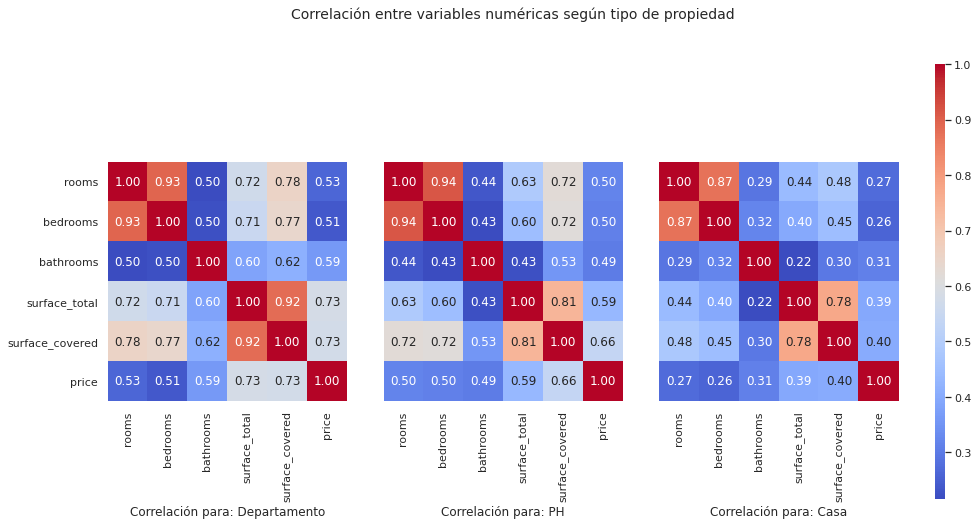

In [ ]:
f,(ax1,ax2,ax3,axcb) = plt.subplots(1,4, 
            gridspec_kw={'width_ratios':[1,1,1,0.04]})
ax1.get_shared_y_axes().join(ax2,ax3)
#en g1 el primero
df1 = df[df['property_type']== 'Departamento']
corr = df1.drop(['property_type'], axis =1).corr()
    
g1 =   sns.heatmap(corr, cbar = False,  square = True, fmt= '.2f', annot=True, annot_kws={'size': 12},
                      cmap= 'coolwarm', ax= ax1)
g1.set_xlabel('Correlación para: ' + 'Departamento')
g1.set_ylabel('')

#en g2 el segundo
df2 = df[df['property_type']== 'PH']
corr = df2.drop(['property_type'], axis =1).corr()
    
g2 =   sns.heatmap(corr, cbar = False,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 12},
           cmap= 'coolwarm', ax= ax2)
g2.set_xlabel('Correlación para: ' + 'PH')
g2.set_ylabel('')
g2.set_yticks([])

#en g3
df3 = df[df['property_type']== 'Casa']
corr = df3.drop(['property_type'], axis =1).corr()
    
g3 =   sns.heatmap(corr,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 12},
                      cmap= 'coolwarm', ax= ax3, cbar = True, cbar_ax = axcb)
g3.set_xlabel('Correlación para: ' + 'Casa')
g3.set_ylabel('')
g3.set_yticks([])

f.suptitle("Correlación entre variables numéricas según tipo de propiedad", fontsize=14)
plt.show()

Se podría investigar también en qué *regiones* las propiedades son más caras, incluso podemos visualizar esta información distinguiendo por *tipo de propiedad*. Esta información podría estar igualmente sesgada debido a que nos restringimos a las propiedades publicadas en este canal de venta.

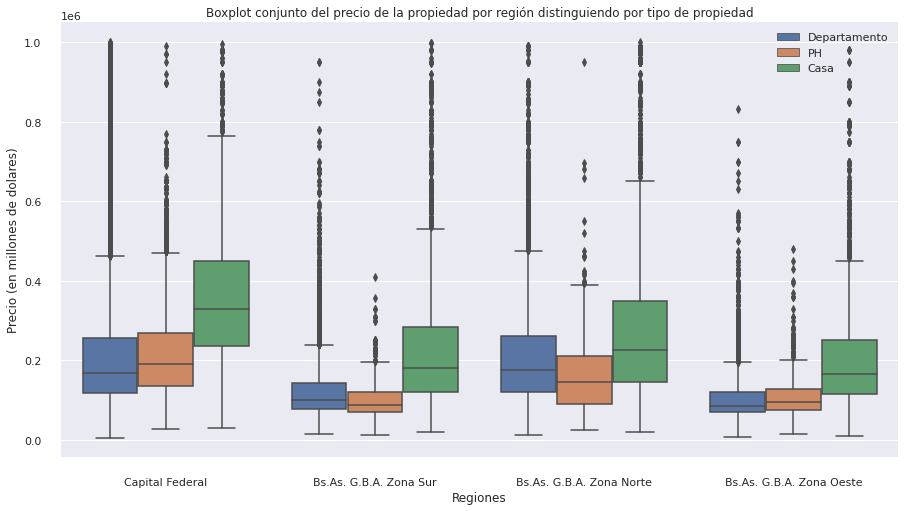

In [ ]:
propDPC = properati[properati.property_type.isin(['Departamento', 'Casa', 'PH'])] 
propDPC = propDPC[propDPC.price <1000000]
sns.boxplot(x="l2", y="price",
            hue="property_type", 
            data= propDPC)
sns.despine(offset=10, trim=True)
plt.legend(loc='upper right', frameon=False)
plt.xlabel('Regiones')
plt.ylabel('Precio (en millones de dolares)')
plt.title('Boxplot conjunto del precio de la propiedad por región distinguiendo por tipo de propiedad');
plt.show()

Vemos en este gráfico que las propiedades de *Capital Federal* son más caras (en promedio) que en el resto de las regiones. Las regiones cuyas propiedades son más baratas se encuentran en la provincia de Buenos Aires en las zonas Sur y Oeste. Así mismo observamos con claridad en este gráfico que las propiedades de tipo *Casa* son mas caras (en promedio). Con respecto a los precios de las propiedades en general los promedios toman valores entre cien mil y cuatrocientos mil dolares. Vemos que los *bigotes* y los *outliers* de los *boxplot* tienden a tomar valores mayores llegando hasta el millon de dolares.

l3
Puerto Madero      555261.108696
Las Cañitas        379773.777018
Recoleta           329810.460854
Belgrano           305121.384781
San Isidro         295788.681631
                       ...      
Villa Soldati      122472.463768
Boca               120780.071642
Tres de Febrero    116831.068780
Constitución       103759.853814
José C Paz          87332.267148
Name: price, Length: 89, dtype: float64


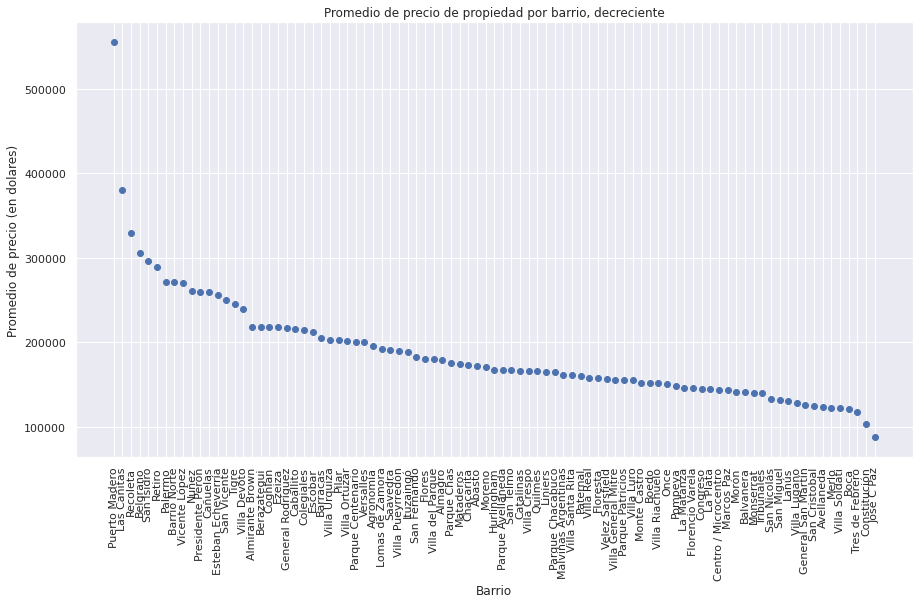

In [ ]:
grouped = propDPC.groupby(['l3']).mean()['price']
print(grouped.sort_values(ascending=False))

plt.plot(grouped.sort_values(ascending=False),'ob')
plt.title('Promedio de precio de propiedad por barrio, decreciente')
plt.ylabel('Promedio de precio (en dolares)')
plt.xlabel('Barrio')
plt.xticks(rotation='vertical');
plt.show()

Podemos conlcuir que los tres barrios mas caros del Gran Buenos Aires (dentro de los datos que disponemos) son:


1.   Puerto Madero - Precio promedio de US\$555.000
2.   Las Cañitas   - Precio promedio de US\$379.000
3.   Recoleta      - Precio promedio de US\$329.000

Mientras que Los tres barrios más baratos del Gran Buenos Aires (dentro de los datos que disponemos) son:

1.   José C Paz - Precio promedio de US\$87.000
2.   Constitución   - Precio promedio de US\$103.000
3.   Tres de Febrero      - Precio promedio de US\$116.000




### 3. Machine Learning

En esta sección, entrenamos dos modelos de Machine Learning - uno de vecinos más cercanos y otro de árboles de decisión -  para predecir el precio de las propiedades tipo `Departamento`, `PH` y `Casa`  en la Ciudad Autónoma de Buenos Aires (`Capital Federal`). 


**Importante:** como una primera aproximación realizamos el siguiente filtrado:

1. Seleccionamos aquellas propiedades en Capital Federal y cuyo tipo de propiedad es Departamento, PH o Casa.
1. Seleccionamos aquellas propiedades cuya superficie total es menor a 1000 m2 y mayor a 15 m2.
1. Seleccionamos aquellas propiedades cuya precio es menor 4000000 dólares.
1. Seleccionamos las columnas `rooms`, `bedrooms`, `bathrooms`, `surface_total`, `surface_covered` y `price`.
1. Descartamos aquellas instacias con valores faltantes.


# Métrica de evaluación
La métrica elegida para evaluar los modelos es la raíz cuadrada del error cuadrático medio (RECM). Definida por:
$$
RECM(y,y^*) = \sqrt{\frac{1}{n}\sum_{j=1}^n \left(y_j - y_j^* \right)^2}
$$
Es una de las métricas estandar para evaluar modelos de regresión. Es la norma 2 entre los vectores a predecir ($y$) y las predicciones ($y^*$).
Al ser un (múltiplo de una) norma, toma valores en $[0,+\infty)$. Cabe notar, que cuanto menor sea el valor del RECM, mejor será el desempeño del modelo. El caso $RECM=0$ equivale a la igualdad $y=y^*$. Esta métrica se mide en las mismas unidades que la variable $y$, en nuestro caso US\$.
Se podría haber seleccionado otra métrica como ser por ejemplo el MAE, error absoluto medio. Esta métrica proviene de la norma 1. Existen ventajas y desventajas entre una y la otra aunque provienen de normas equivalentes. En general, MAE es menor o igual a RECM. La métrica RECM es diferenciable. La métrica RECM está asocidad al promedio, mientras que el MAE a la mediana, por esta razón MAE es más robusto.




**Realizamos el filtrado pedido y comprobamos el checkpoint.**

In [ ]:
df0 = pd.read_csv("DS_Proyecto_01_Datos_Properati.csv",parse_dates=['created_on'])
df0 = df0[df0.property_type.isin(['Departamento', 'Casa', 'PH'])] 
df0 = df0[df0.l2=='Capital Federal']
df0 = df0[df0['surface_total']<=1000]
df0 = df0[df0['surface_total']>=15]
df0 = df0[df0['price']<=4000000]
df0 = df0.drop(['start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1', 'l2', 'l3',
     'currency', 'title', 'description', 'operation_type', 'property_type'], axis =1)
df0 = df0.dropna()
print('El tamaño del dataset df0 es:')
df0.shape

El tamaño del dataset df0 es:


(81019, 6)

Corremos un primer modelo de regresión lineal para predecir la variable *precio*. Imprimimos en pantalla el error obtenido para este modelo. Notamos que estamos trabajando con la raiz cuadrada del error cuadrático medio (RECM).

In [ ]:
X = df0.drop(['price'], axis = 1)
y = df0.price

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)


# The mean squared error
print('RECM para el modelo de Regresión lineal: %.2f'
      % np.sqrt(mean_squared_error(y_test, y_pred)))
error_lineal = np.sqrt(mean_squared_error(y_test, y_pred))

RECM para el modelo de Regresión lineal: 202375.16


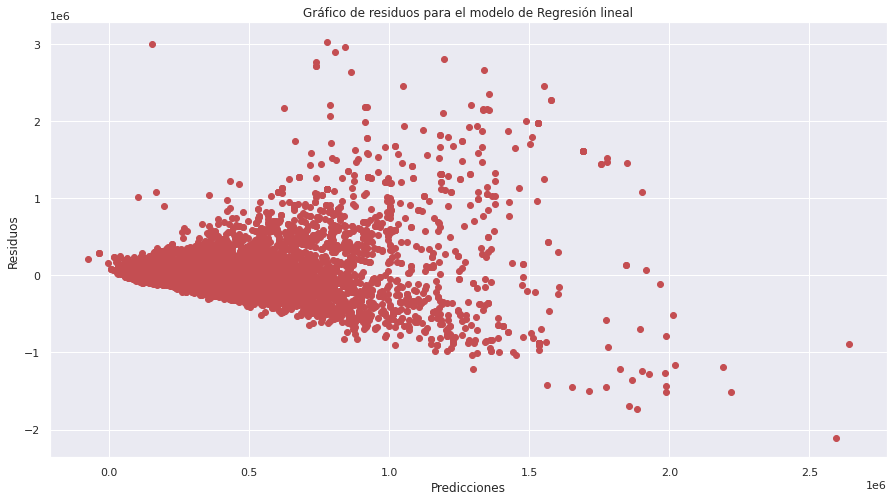

In [ ]:
residuals = y_test-y_pred
plt.scatter(y_pred,residuals,c='r')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Gráfico de residuos para el modelo de Regresión lineal')
plt.show()

Entrenamos modelos de vecinos más cercanos y de árbol de decisión. Optimizamos el desempeño de los modelos estudiando el número de vecinos y la profundidad del árbol, respectivamente. Graficamos en cada uno de los modelos el RECM en el conjunto de train y en el conjunto de test.

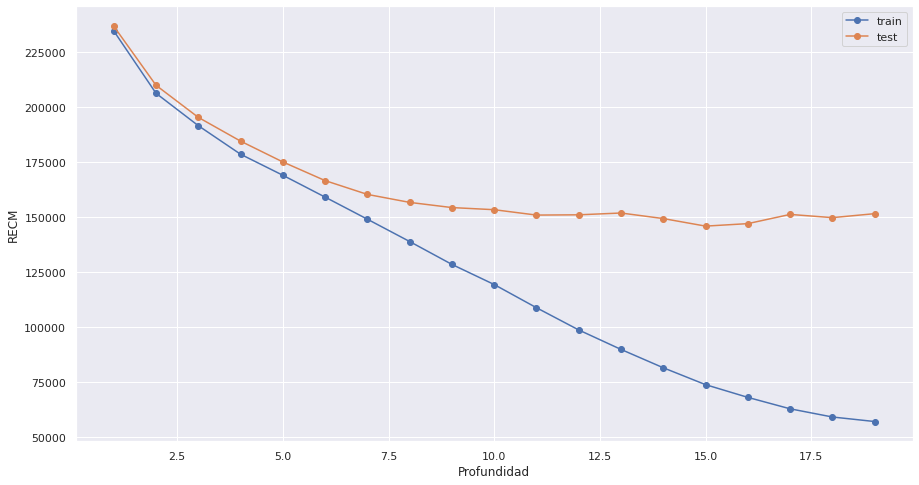

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Profundidad para arbol

# Definimos las listas vacias para los valores de accuracy deseados
lista_recm_train_a = []
lista_recm_test_a = []

# Definimos la lista de valores de k que vamos a explorar
profundidad = range(1, 20)

# Generamos en loop sobre los distintos valores de k 
for p in profundidad:
    
    # Vamos a repetir el siguiente bloque de código
    
    # Definir el modelo con el valor de vecinos deseado
    clf = DecisionTreeRegressor(max_depth = p, random_state = 42)
    
    # Entrenar el modelo
    clf.fit(X_train,y_train)
    
    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred = clf.predict(X_train)
    train_recm = np.sqrt(mean_squared_error(y_train, y_train_pred))
    
    # Predecir y evaluar sobre el set de evaluación
    y_test_pred = clf.predict(X_test)
    test_recm = np.sqrt(mean_squared_error(y_test , y_test_pred))
    
    # Agregar la información a las listas
    lista_recm_train_a.append(train_recm)
    lista_recm_test_a.append(test_recm)

plt.plot(profundidad, lista_recm_train_a,'o-', label='train')
plt.plot(profundidad, lista_recm_test_a, 'o-', label='test' )
plt.legend()
plt.xlabel('Profundidad')
plt.ylabel('RECM')
plt.show()

In [ ]:
print('El mínimo error en test para el árbol es: %.2f, que se obtiene con Profundidad igual a 15.'
      % min(lista_recm_test_a))
print('Sin embargo vemos que a partir de Profundidad mayor o igual a 9, la curva de errores en test aparenta ser casi constante.') 
print('Por lo tanto, seleccionamos como mejor modelo el árbol de desición con Profundidad igual a 9, cuyo error es: %.2f' % lista_recm_test_a[8])
error_arbol = lista_recm_test_a[8]


El mínimo error en test para el árbol es: 145784.93, que se obtiene con Profundidad igual a 15.
Sin embargo vemos que a partir de Profundidad mayor o igual a 9, la curva de errores en test aparenta ser casi constante.
Por lo tanto, seleccionamos como mejor modelo el árbol de desición con Profundidad igual a 9, cuyo error es: 154208.32


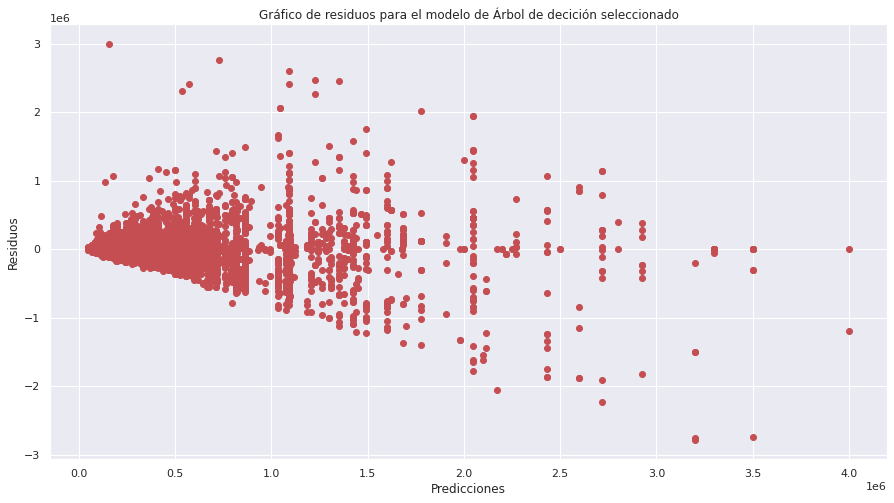

In [ ]:
clf = DecisionTreeRegressor(max_depth = 9, random_state = 42)
    
# Entrenar el modelo
clf.fit(X_train,y_train)
    
# Predecir y evaluar sobre el set de entrenamiento
y_train_a_pred = clf.predict(X_train)
train_a_recm = np.sqrt(mean_squared_error(y_train, y_train_a_pred))
    
# Predecir y evaluar sobre el set de evaluación
y_test_a_pred = clf.predict(X_test)
test_a_recm = np.sqrt(mean_squared_error(y_test , y_test_a_pred))

residuals_a = y_test-y_test_a_pred
plt.scatter(y_test_a_pred,residuals_a,c='r')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Gráfico de residuos para el modelo de Árbol de decición seleccionado')
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

Text(0, 0.5, 'RECM')

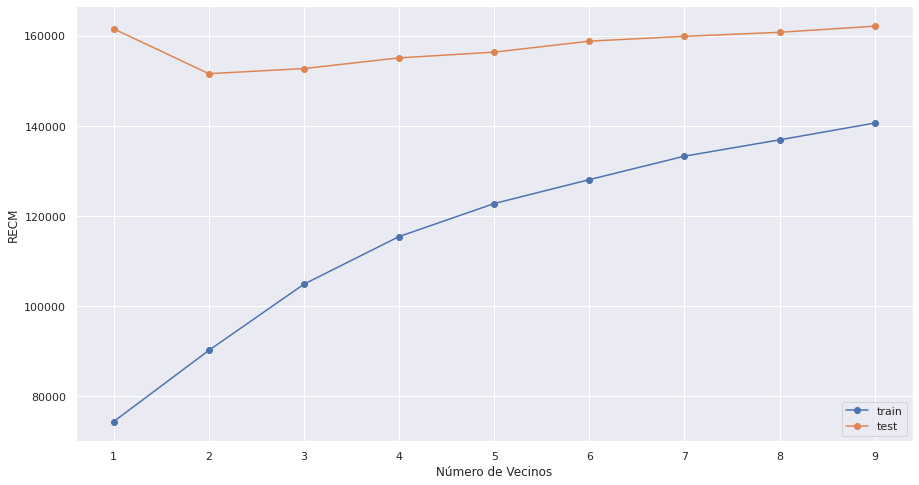

In [ ]:

# Mejor k para kNN

# Definimos las listas vacias para los valores de accuracy deseados
lista_recm_train_v = []
lista_recm_test_v = []

# Definimos la lista de valores de k que vamos a explorar
k_vecinos = range(1, 10)

# Generamos en loop sobre los distintos valores de k 
for k in k_vecinos:
    
    # Vamos a repetir el siguiente bloque de código
    
    # Definir el modelo con el valor de vecinos deseado
    clf = KNeighborsRegressor(k)
    
    # Entrenar el modelo
    clf.fit(X_train,y_train)
    
    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred = clf.predict(X_train)
    train_recm = np.sqrt(mean_squared_error(y_train, y_train_pred))
    
    # Predecir y evaluar sobre el set de evaluación
    y_test_pred = clf.predict(X_test)
    test_recm = np.sqrt(mean_squared_error(y_test , y_test_pred))
    
    # Agregar la información a las listas
    lista_recm_train_v.append(train_recm)
    lista_recm_test_v.append(test_recm)

plt.plot(k_vecinos, lista_recm_train_v,'o-', label='train')
plt.plot(k_vecinos, lista_recm_test_v, 'o-', label='test' )
plt.legend()
plt.xlabel('Número de Vecinos')
plt.ylabel('RECM')

In [ ]:
print('El mínimo error en test para el modelo de vecinos es: %.2f, que se obtiene con Número de Vecinos igual a 2.'
      % min(lista_recm_test_v))
print('Observamos que la curva de errores en test aparenta ser casi constante.') 
print('Por lo tanto, seleccionamos como mejor modelo de vecinos más cercanos con número de vecinos igual a 2.')
error_vecinos = lista_recm_test_v[1]


El mínimo error en test para el modelo de vecinos es: 151555.75, que se obtiene con Número de Vecinos igual a 2.
Observamos que la curva de errores en test aparenta ser casi constante.
Por lo tanto, seleccionamos como mejor modelo de vecinos más cercanos con número de vecinos igual a 2.


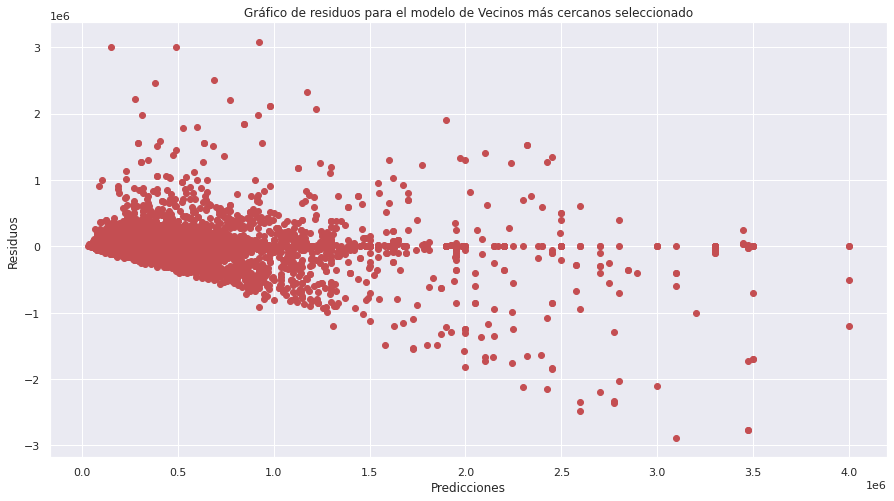

In [ ]:
# Definir el modelo con el valor de vecinos deseado
clf = KNeighborsRegressor(2)
    
# Entrenar el modelo
clf.fit(X_train,y_train)
    
# Predecir y evaluar sobre el set de entrenamiento
y_train_v_pred = clf.predict(X_train)
train_v_recm = np.sqrt(mean_squared_error(y_train, y_train_v_pred))
    
# Predecir y evaluar sobre el set de evaluación
y_test_v_pred = clf.predict(X_test)
test_v_recm = np.sqrt(mean_squared_error(y_test , y_test_v_pred))

residuals_v = y_test-y_test_v_pred
plt.scatter(y_test_v_pred,residuals_v,c='r')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Gráfico de residuos para el modelo de Vecinos más cercanos seleccionado')
plt.show()

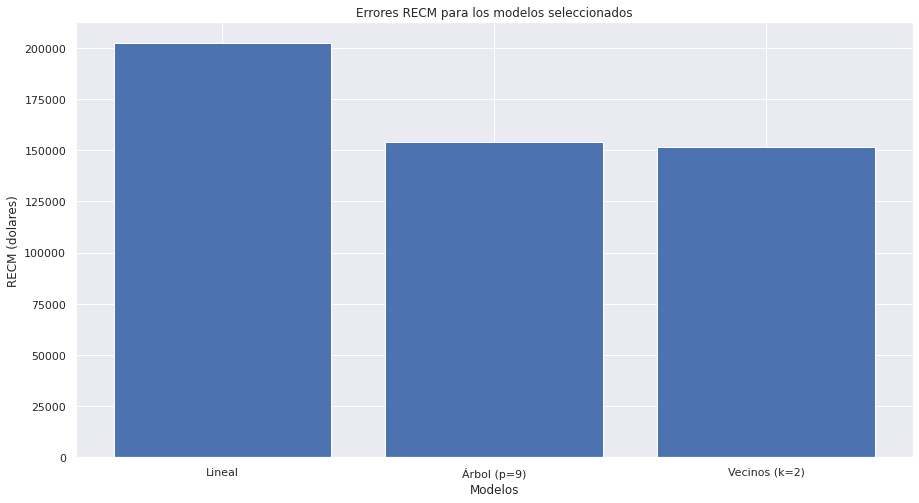

In [ ]:
x=np.arange(3)
errores = [error_lineal, error_arbol, error_vecinos]
plt.bar(x, errores)
plt.xticks(x, ('Lineal', 'Árbol (p=9)', 'Vecinos (k=2)'))
plt.xlabel('Modelos')
plt.ylabel('RECM (dolares)')
plt.title('Errores RECM para los modelos seleccionados')
plt.show()

De los tres modelos comparados, vemos que el que tiene menor RECM es el modelo de Vecinos más cercanos con hiperparámetro $k=2$. Sin embargo, vemos que el desempeño del árbol de decisión es relativamente similar. Dado que los residuos en los tres modelos son del orden del millón de dolares, procedemos a realizar modelos tomando logaritmo a la variable precio. Agregamos las variables *lat* y *lon* al modelo. Volvemos a correr modelos de regresión lineal y de Vecinos más cercanos con hiperparámetro número de vecinos igual a 2.

RECM log-LS: 693376.5632426353


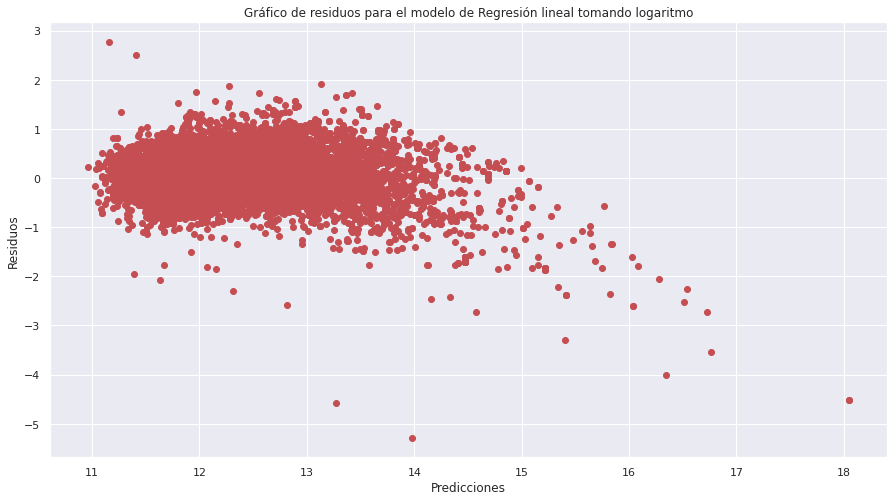

RECM log-Vecinos: 135073.1763996685


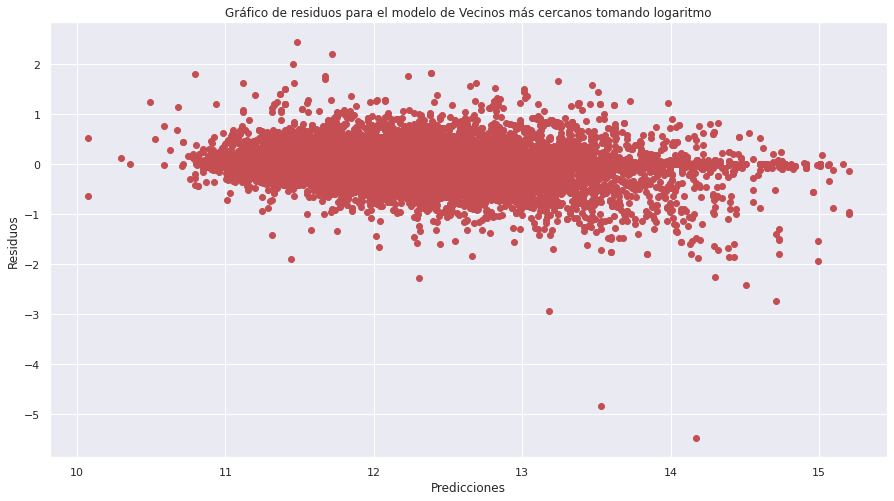

In [ ]:
df2 = pd.read_csv("DS_Proyecto_01_Datos_Properati.csv",parse_dates=['created_on'])
df2 = df2[df2.property_type.isin(['Departamento', 'Casa', 'PH'])] 
df2 = df2[df2.l2=='Capital Federal']
df2 = df2[df2['surface_total']<=1000]
df2 = df2[df2['surface_total']>=15]
df2 = df2[df2['price']<=4000000]
df2 = df2.drop(['start_date', 'end_date', 'created_on', 'l1', 'l2', 'l3',
     'currency', 'title', 'description', 'operation_type', 'property_type'], axis =1)
df2 = df2.dropna()

A = df2.drop(['price'], axis = 1)
b = np.log(df2.price)

X_train1, X_test1, y_train1, y_test1 = train_test_split(A, b, test_size=0.33, random_state=42)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train1, y_train1)

# Make predictions using the testing set
y_pred1 = regr.predict(X_test1)

print('RECM log-LS: ' + str(np.sqrt(mean_squared_error(np.exp(y_test1) , np.exp(y_pred1)))))

residuals1 = y_test1-y_pred1
plt.scatter(y_pred1,residuals1,c='r')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Gráfico de residuos para el modelo de Regresión lineal tomando logaritmo')
plt.show()

clf = KNeighborsRegressor(2)
    
# Entrenar el modelo
clf.fit(X_train1,y_train1)
    
# Predecir y evaluar sobre el set de entrenamiento
y_train_v_pred1 = clf.predict(X_train1)
train_v_recm1 = np.sqrt(mean_squared_error(y_train1, y_train_v_pred1))
    
# Predecir y evaluar sobre el set de evaluación
y_test_v_pred1 = clf.predict(X_test1)
test_v_recm1 = np.sqrt(mean_squared_error(np.exp(y_test1) , np.exp(y_test_v_pred1)))

print('RECM log-Vecinos: '+str(test_v_recm1))

residuals_v1 = y_test1-y_test_v_pred1
plt.scatter(y_test_v_pred1,residuals_v1,c='r')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Gráfico de residuos para el modelo de Vecinos más cercanos tomando logaritmo')
plt.show()

**Observamos que la distribución de los residuos del modelo de Vecinos más cercanos se estabilizó. Vemos residuos con esperanza $0$, cuyo gráfico no tiene estructura (aparenta aleatorio con una leve tendencia a residuos negativos para predicciones altas). Además el valor del RECM agregando las variables *lat* y *lon* descendió a 135073.**

**Dentro de la información que estamos repitiendo tenemos la alta correlación hallada entre las variables *rooms* y *bedrooms* y entre las variables *surface_total* y *surface_covered*. La información que no estamos usando para entrenar al modelo son las variables categóricas como $l_2$ y $l_3$ (Región y Barrio) y *property_type*. Vimos en los desafíos que estas tres variables importan a la hora de determinar el precio de una propiedad. Tampoco usamos información respecto a la duración de la publicación en el portal (podríamos evaluar el supuesto de que *propiedades que se venden rápidamente estaban publicadas a precios convenientes*). Adicionalmente se podría plantear un estudio de palabras clave en el título y/o en la descripción que podrían ayudar a entrenar los modelos (ejemplos: *barato*, *oportunidad*, *a estrenar*).**